# How to Explore the GAN Latent Space When Generating Faces
Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.

The generative model in the GAN architecture learns to map points in the latent space to generated images. The latent space has no meaning other than the meaning applied to it via the generative model. Yet, the latent space has structure that can be explored, such as by interpolating between points and performing vector arithmetic between points in latent space which have meaningful and targeted effects on the generated images.

In this tutorial, you will discover how to develop a generative adversarial network for face generation and explore the structure of latent space and the effect on generated faces.

After completing this tutorial, you will know:

- How to develop and evaluate a generative adversarial network for generating faces.
- How to interpolate between points in latent space and generate images that morph from one face to another.
- How to perform vector arithmetic in latent space and achieve targeted results in the resulting generated faces.

## Tutorial Overview

This tutorial is divided into five parts; they are:

1. Vector Arithmetic in Latent Space
2. Large-Scale CelebFaces Dataset (CelebA)
3. How to Develop a Generative Adversarial Network
4. How to Evaluate a Generative Adversarial Network
5. How to Explore the Latent Space for Generated Faces

## Vector Arithmetic in Latent Space
The generator model in the GAN architecture takes a point from the latent space as input and generates a new image.

The latent space itself has no meaning. Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one. Through training, the generator learns to map points into the latent space with specific output images and this mapping will be different each time the model is trained.

The latent space has structure when interpreted by the generator model, and this structure can be queried and navigated for a given model.

Typically, new images are generated using random points in the latent space. Taken a step further, points in the latent space can be constructed (e.g. all 0s, all 0.5s, or all 1s) and used as input or a query to generate a specific image.

A series of points can be created on a linear path between two points in the latent space, such as two generated images. These points can be used to generate a series of images that show a transition between the two generated images.

Finally, the points in the latent space can be kept and used in simple vector arithmetic to create new points in the latent space that, in turn, can be used to generate images. This is an interesting idea, as it allows for the intuitive and targeted generation of images.

The important 2015 paper by Alec Radford, et al. titled “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks” introduced a stable model configuration for training deep convolutional neural network models as part of the GAN architecture.

In the paper, the authors explored the latent space for GANs fit on a number of different training datasets, most notably a dataset of celebrity faces. They demonstrated two interesting aspects.

The first was the vector arithmetic with faces. For example, a face of a smiling woman minus the face of a neutral woman plus the face of a neutral man resulted in the face of a smiling man.

Specifically, the arithmetic was performed on the points in the latent space for the resulting faces. Actually on the average of multiple faces with a given characteristic, to provide a more robust result.

![Example of Vector Arithmetic on Points in the Latent Space for Generating Faces With a GAN.](https://machinelearningmastery.com/wp-content/uploads/2019/05/Example-of-Vector-Arithmetic-on-Points-in-the-Latent-Space-for-Generating-Faces-with-a-GAN-1024x531.png)

The second demonstration was the transition between two generated faces, specifically by creating a linear path through the latent dimension between the points that generated two faces and then generating all of the faces for the points along the path.

![Example of Faces on a Path Between Two GAN Generated Faces.](https://machinelearningmastery.com/wp-content/uploads/2019/05/Example-of-Faces-on-a-Path-Between-Two-GAN-Generated-Faces-1024x606.png)

Exploring the structure of the latent space for a GAN model is both interesting for the problem domain and helps to develop an intuition for what has been learned by the generator model.

In this tutorial, we will develop a GAN for generating photos of faces, then explore the latent space for the model with vector arithmetic.

## Large-Scale CelebFaces Dataset (CelebA)
The first step is to select a dataset of faces.

In this tutorial, we will use the Large-scale CelebFaces Attributes Dataset, referred to as CelebA. This dataset was developed and published by Ziwei Liu, et al. for their 2015 paper titled “[From Facial Parts Responses to Face Detection: A Deep Learning Approach](https://arxiv.org/abs/1509.06451)”.

The dataset provides about 200,000 photographs of celebrity faces along with annotations for what appears in given photos, such as glasses, face shape, hats, hair type, etc. As part of the dataset, the authors provide a version of each photo centered on the face and cropped to the portrait with varying sizes around 150 pixels wide and 200 pixels tall. We will use this as the basis for developing our GAN model.

The prepared dataset can be downloaded as follows:

In [ ]:
!wget 'https://nextcloud.univ-lille.fr/index.php/s/fJCDx8XCRdzDg3y/download/img_align_celeba.npz'

--2022-10-19 14:03:41--  https://nextcloud.univ-lille.fr/index.php/s/fJCDx8XCRdzDg3y/download/img_align_celeba.npz
Resolving nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)... 194.254.129.23, 194.254.129.22
Connecting to nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)|194.254.129.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888614524 (847M) [application/octet-stream]
Saving to: ‘img_align_celeba.npz’

img_align_celeba.np 100%[===================>] 847.45M  30.8MB/s    in 29s     

2022-10-19 14:04:11 (29.6 MB/s) - ‘img_align_celeba.npz’ saved [888614524/888614524]



The prepared dataset can then be loaded as follows:

In [ ]:
from numpy import load

# load the face dataset
data = load('img_align_celeba.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)

Loaded:  (50000, 80, 80, 3)


Once the images are loaded, we can plot them using the imshow() function from the matplotlib library.

The plot_faces() function below does this, plotting images arranged into in a square.

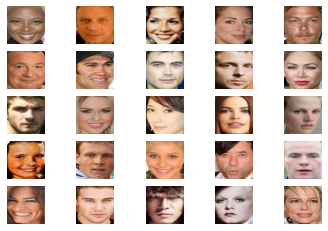

In [ ]:
from matplotlib import pyplot

# plot a list of loaded faces
def plot_faces(faces, n):
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(faces[i])
	pyplot.show()

plot_faces(faces, 5)

## 3. How to Develop a Generative Adversarial Network
In this section, we will develop a GAN for the faces dataset that we have prepared.

The first step is to define the models.

The discriminator model takes as input one 80×80 color image an outputs a binary prediction as to whether the image is real (class=1) or fake (class=0). It is implemented as a modest convolutional neural network using best practices for GAN design such as using the LeakyReLU activation function with a slope of 0.2, using a 2×2 stride to downsample, and the adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5

The define_discriminator() function below implements this, defining and compiling the discriminator model and returning it. The input shape of the image is parameterized as a default function argument in case you want to re-use the function for your own image data later.

In [ ]:
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout

# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

The generator model takes as input a point in the latent space and outputs a single 80×80 color image.

This is achieved by using a fully connected layer to interpret the point in the latent space and provide sufficient activations that can be reshaped into many copies (in this case 128) of a low-resolution version of the output image (e.g. 5×5). This is then upsampled four times, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers. The model uses best practices such as the LeakyReLU activation, a kernel size that is a factor of the stride size, and a hyperbolic tangent (tanh) activation function in the output layer.

The define_generator() function below defines the generator model but intentionally does not compile it as it is not trained directly, then returns the model. The size of the latent space is parameterized as a function argument.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import LeakyReLU

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

Next, a GAN model can be defined that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only has an effect when training the combined GAN model, not when training the discriminator standalone.

This larger GAN model takes as input a point in the latent space, uses the generator model to generate an image, which is fed as input to the discriminator model, then output or classified as real or fake.

The define_gan() function below implements this, taking the already-defined generator and discriminator models as input.

In [ ]:
from keras.optimizers import adam_v2
from keras.models import Sequential

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Now that we have defined the GAN model, we need to train it. But, before we can train the model, we require input data.

The first step is to load and scale the pre-processed faces dataset. The saved NumPy array can be loaded, as we did in the previous section, then the pixel values must be scaled to the range [-1,1] to match the output of the generator model.

The load_real_samples() function below implements this, returning the loaded and scaled image data ready for modeling.

In [ ]:
from numpy import load

# load and prepare training images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

We will require one batch (or a half) batch of real images from the dataset each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

The generate_real_samples() function below implements this, taking the prepared dataset as an argument, selecting and returning a random sample of face images and their corresponding class label for the discriminator, specifically class=1, indicating that they are real images.

In [ ]:
from numpy import ones
from numpy.random import randint

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

Next, we need inputs for the generator model. These are random points from the latent space, specifically Gaussian distributed random variables.

The generate_latent_points() function implements this, taking the size of the latent space as an argument and the number of points required and returning them as a batch of input samples for the generator model.

In [ ]:
from numpy.random import randn

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Next, we need to use the points in the latent space as input to the generator in order to generate new images.

The generate_fake_samples() function below implements this, taking the generator model and size of the latent space as arguments, then generating points in the latent space and using them as input to the generator model. The function returns the generated images and their corresponding class label for the discriminator model, specifically class=0 to indicate they are fake or generated.

In [ ]:
from numpy import zeros

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

We are now ready to fit the GAN models.

The model is fit for 100 training epochs, which is arbitrary, as the model begins generating plausible faces after perhaps the first few epochs. A batch size of 128 samples is used, and each training epoch involves 50,000/128 or about 390 batches of real and fake samples and updates to the model.

First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the combined GAN model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.

The train() function below implements this, taking the defined models, dataset, and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments.

There is currently no reliable way to automatically evaluate the quality of generated images. Therefore, we must generate images periodically during training and save the model at these times. This both provides a check-point that we can later load and use to generate images, and a way to safeguard against the training process failing, which can happen.

Below defines the summarize_performance() and save_plot() functions.

The summarize_performance() function generates samples and evaluates the performance of the discriminator on real and fake samples. The classification accuracy is reported and might provide insight into model performance. The save_plot() is called to create and save a plot of the generated images, and then the model is saved to a file.

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

We can then define the size of the latent space, define all three models, and train them on the loaded face dataset.

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 19ms/step
>4, 232/390, d1=0.254, d2=0.067 g=3.969
2/2 [==============================] - 0s 19ms/step
>4, 233/390, d1=0.176, d2=0.266 g=4.837
2/2 [==============================] - 0s 18ms/step
>4, 234/390, d1=0.141, d2=0.029 g=4.698
2/2 [==============================] - 0s 19ms/step
>4, 235/390, d1=0.150, d2=0.130 g=3.980
2/2 [==============================] - 0s 18ms/step
>4, 236/390, d1=0.263, d2=0.283 g=4.491
2/2 [==============================] - 0s 20ms/step
>4, 237/390, d1=0.245, d2=0.087 g=3.932
2/2 [==============================] - 0s 19ms/step
>4, 238/390, d1=0.450, d2=0.488 g=4.261
2/2 [==============================] - 0s 19ms/step
>4, 239/390, d1=0.368, d2=0.138 g=4.338
2/2 [==============================] - 0s 18ms/step
>4, 240/390, d1=0.190, d2=0.105 g=3.985
2/2 [==============================] - 0s 22ms/step
>4, 241/390, d1=0.297, d2=0.250 g=4.324
2/

2/2 [==============================] - 0s 22ms/step
>11, 1/390, d1=0.334, d2=0.149 g=3.243
2/2 [==============================] - 0s 18ms/step
>11, 2/390, d1=0.289, d2=0.303 g=3.603
2/2 [==============================] - 0s 19ms/step
>11, 3/390, d1=0.349, d2=0.243 g=2.917
2/2 [==============================] - 0s 18ms/step
>11, 4/390, d1=0.269, d2=0.317 g=3.158
2/2 [==============================] - 0s 18ms/step
>11, 5/390, d1=0.287, d2=0.300 g=3.388
2/2 [==============================] - 0s 18ms/step
>11, 6/390, d1=0.440, d2=0.404 g=3.728
2/2 [==============================] - 0s 18ms/step
>11, 7/390, d1=0.426, d2=0.273 g=3.432
2/2 [==============================] - 0s 18ms/step
>11, 8/390, d1=0.386, d2=0.331 g=3.676
2/2 [==============================] - 0s 18ms/step
>11, 9/390, d1=0.594, d2=0.320 g=2.911
2/2 [==============================] - 0s 18ms/step
>11, 10/390, d1=0.276, d2=0.329 g=3.062
2/2 [==============================] - 0s 18ms/step
>11, 11/390, d1=0.438, d2=0.421 g=2.8

Tying all of this together, the complete example is listed below.

In [ ]:

# example of a gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare training images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Running the example may take a long time on modest hardware.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

The loss for the discriminator on real and fake samples, as well as the loss for the generator, is reported after each batch.

In [ ]:
>1, 1/390, d1=0.699, d2=0.696 g=0.692
>1, 2/390, d1=0.541, d2=0.702 g=0.686
>1, 3/390, d1=0.213, d2=0.742 g=0.656
>1, 4/390, d1=0.013, d2=0.806 g=0.656
>1, 5/390, d1=0.012, d2=0.772 g=0.682
...

The discriminator loss may crash down to values of 0.0 for real and generated samples.

If this happens, it is an example of a training failure from which the model is likely to not recover and you should restart the training process.

In [ ]:
...
>34, 130/390, d1=0.844, d2=8.434 g=3.450
>34, 131/390, d1=1.233, d2=12.021 g=3.541
>34, 132/390, d1=1.183, d2=15.759 g=0.000
>34, 133/390, d1=0.000, d2=15.942 g=0.006
>34, 134/390, d1=0.081, d2=15.942 g=0.000
>34, 135/390, d1=0.000, d2=15.942 g=0.000
...

Review the generated plots and select a model based on the best quality images.

The model should begin to generate faces after about 30 training epochs.

The faces are not completely clear, but it is obvious that they are faces, with all the right things (hair, eyes, nose, mouth) in roughly the right places.

The generator model can be downloaded as follows:

In [ ]:
!wget 'https://nextcloud.univ-lille.fr/index.php/s/stkf2XASKxsHaLD/download/generator_model_030.h5'

--2022-02-23 09:14:01--  https://nextcloud.univ-lille.fr/index.php/s/stkf2XASKxsHaLD/download/generator_model_030.h5
Resolving nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)... 194.254.129.23, 194.254.129.22
Connecting to nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)|194.254.129.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5564160 (5.3M) [application/octet-stream]
Saving to: ‘generator_model_030.h5’

generator_model_030 100%[===================>]   5.31M  6.25MB/s    in 0.8s    

2022-02-23 09:14:02 (6.25 MB/s) - ‘generator_model_030.h5’ saved [5564160/5564160]



## How to Evaluate a Generative Adversarial Network

The Frechet Inception Distance score, or FID for short, is a metric that calculates the distance between feature vectors calculated for real and generated images.

The score summarizes how similar the two groups are in terms of statistics on computer vision features of the raw images calculated using the inception v3 model used for image classification. Lower scores indicate the two groups of images are more similar, or have more similar statistics, with a perfect score being 0.0 indicating that the two groups of images are identical.

The FID score is used to evaluate the quality of images generated by generative adversarial networks, and lower scores have been shown to correlate well with higher quality images.

In the following, you will discover how to implement the Frechet Inception Distance for evaluating generated images.

### What Is the Frechet Inception Distance?
The Frechet Inception Distance, or FID for short, is a metric for evaluating the quality of generated images and specifically developed to evaluate the performance of generative adversarial networks.

The FID score was proposed and used by Martin Heusel, et al. in their 2017 paper titled “GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium.”

The score was proposed as an improvement over the existing Inception Score, or IS.

The inception score estimates the quality of a collection of synthetic images based on how well the top-performing image classification model Inception v3 classifies them as one of 1,000 known objects. The scores combine both the confidence of the conditional class predictions for each synthetic image (quality) and the integral of the marginal probability of the predicted classes (diversity).

The inception score does not capture how synthetic images compare to real images. The goal in developing the FID score was to evaluate synthetic images based on the statistics of a collection of synthetic images compared to the statistics of a collection of real images from the target domain.

Like the inception score, the FID score uses the inception v3 model. Specifically, the coding layer of the model (the last pooling layer prior to the output classification of images) is used to capture computer-vision-specific features of an input image. These activations are calculated for a collection of real and generated images.

The activations are summarized as a multivariate Gaussian by calculating the mean and covariance of the images. These statistics are then calculated for the activations across the collection of real and generated images.

The distance between these two distributions is then calculated using the Frechet distance, also called the Wasserstein-2 distance.

The use of activations from the Inception v3 model to summarize each image gives the score its name of “Frechet Inception Distance.”

A lower FID indicates better-quality images; conversely, a higher score indicates a lower-quality image and the relationship may be linear.

The authors of the score show that lower FID scores correlate with better-quality images when systematic distortions were applied such as the addition of random noise and blur.

![Example of How Increased Distortion of an Image Correlates with High FID Score.](https://machinelearningmastery.com/wp-content/uploads/2019/06/Example-of-How-Increased-Distortion-of-an-Image-Correlates-with-High-FID-Score.png)

### How to Calculate the Frechet Inception Distance
The FID score is calculated by first loading a pre-trained Inception v3 model.

The output layer of the model is removed and the output is taken as the activations from the last pooling layer, a global spatial pooling layer.

This output layer has 2,048 activations, therefore, each image is predicted as 2,048 activation features. This is called the coding vector or feature vector for the image.

A 2,048 feature vector is then predicted for a collection of real images from the problem domain to provide a reference for how real images are represented. Feature vectors can then be calculated for synthetic images.

The result will be two collections of 2,048 feature vectors for real and generated images.

The FID score is then calculated using the following equation taken from the paper:

d^2 = ||mu_1 – mu_2||^2 + Tr(C_1 + C_2 – 2*sqrt(C_1*C_2))
The score is referred to as d^2, showing that it is a distance and has squared units.

The “mu_1” and “mu_2” refer to the feature-wise mean of the real and generated images, e.g. 2,048 element vectors where each element is the mean feature observed across the images.

The C_1 and C_2 are the covariance matrix for the real and generated feature vectors, often referred to as sigma.

The ||mu_1 – mu_2||^2 refers to the sum squared difference between the two mean vectors. Tr refers to the trace linear algebra operation, e.g. the sum of the elements along the main diagonal of the square matrix.

The sqrt is the square root of the square matrix, given as the product between the two covariance matrices.

The square root of a matrix is often also written as M^(1/2), e.g. the matrix to the power of one half, which has the same effect. This operation can fail depending on the values in the matrix because the operation is solved using numerical methods. Commonly, some elements in the resulting matrix may be imaginary, which often can be detected and removed.

### How to Implement the Frechet Inception Distance With Keras
Now that we know how to calculate the FID score and to implement it in NumPy, we can develop an implementation in Keras.

This involves the preparation of the image data and using a pretrained Inception v3 model to calculate the activations or feature vectors for each image.

First, we can load the Inception v3 model in Keras directly.

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3()

This will prepare a version of the inception model for classifying images as one of 1,000 known classes. We can remove the output (the top) of the model via the include_top=False argument. Painfully, this also removes the global average pooling layer that we require, but we can add it back via specifying the pooling=’avg’ argument.

When the output layer of the model is removed, we must specify the shape of the input images, which is 299x299x3 pixels, e.g. the input_shape=(299,299,3) argument.

Therefore, the inception model can be loaded as follows:

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

This model can then be used to predict the feature vector for one or more images.

Our images are likely to not have the required shape. We will use the scikit-image library to resize the NumPy array of pixel values to the required size. The scale_images() function below implements this.

In [ ]:
from numpy import asarray
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

Once resized, the image pixel values will also need to be scaled to meet the expectations for inputs to the inception model. This can be achieved by calling the preprocess_input() function.

We can update our calculate_fid() function defined in the previous section to take the loaded inception model and two NumPy arrays of image data as arguments, instead of activations. The function will then calculate the activations before calculating the FID score.

The calculate_fid() function is listed below.

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of dot product between covariance matrices
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

We can then test this function with some contrived collections of images, in this case, 10 32×32 images with random pixel values in the range [0,255].

In [ ]:
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))

We can then convert the integer pixel values to floating point values and scale them to the required size of 299×299 pixels.


In [ ]:
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))

Then the pixel values can be scaled to meet the expectations of the Inception v3 model.

In [ ]:
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

Then calculate the FID scores, first between a collection of images and itself, then between the two collections of images.

In [ ]:
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Let's calculate the fid score from the real and generated face images.

In [ ]:
from keras.models import load_model

# load image data
dataset = load_real_samples()
# load the generator model
g_model = load_model('generator_model_030.h5')
# get latent dimension
latent_dim = g_model.inputs[0].shape[-1]
# load real and fake images
n_samples = 1000
X_real, _ = generate_real_samples(dataset, n_samples)
X_fake, _ = generate_fake_samples(g_model, latent_dim, n_samples)
# scale from [-1,1] to [0,255]
X_real = X_real * 127.5 + 127.5
X_fake = X_fake * 127.5 + 127.5
# resize images
X_real = scale_images(X_real, (299, 299, 3))
X_fake = scale_images(X_fake, (299, 299, 3))
# pre-process images
X_real = preprocess_input(X_real)
X_fake = preprocess_input(X_fake)
# fid between real and generated images
fid = calculate_fid(model, X_real, X_fake)
print('FID: %.3f' % fid)

## How to Explore the Latent Space for Generated Faces
In this section, we will use our trained GAN model as the basis for exploring the latent space.

### How to Load Model and Generate Faces
The first step is to load the saved model and confirm that it can generate plausible faces.

The model can be loaded using the load_model() function in the Keras API. We can then generate a number of random points in the latent space and use them as input to the loaded model to generate new faces. The faces can then be plotted.

The complete example is listed below.

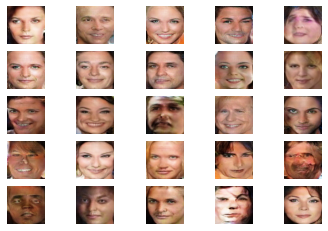

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# create a plot of generated images
def plot_generated(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)

Running the example first loads the saved model.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

Then, 25 random points in the 100-dimensional latent space are created, provided to the generator model to create 25 images of faces, which are then plotted in a 5×5 grid.

### How to Interpolate Between Generated Faces
Next, we can create an interpolation path between two points in the latent space and generate faces along this path.

The simplest interpolation we can use is a linear or uniform interpolation between two points in the latent space. We can achieve this using the linspace() NumPy function to calculate ratios of the contribution from two points, then enumerate these ratios and construct a vector for each ratio.

The interpolate_points() function below implements this and returns a series of linearly interpolated vectors between two points in latent space, including the first and last point.

In [ ]:
from numpy import linspace
from numpy import asarray

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

We can then generate two points in the latent space, perform the interpolation, then generate an image for each interpolated vector.

The result will be a series of images that transition between the two original images. The example below demonstrates this for two faces.

In [ ]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		pyplot.subplot(1, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

Running the example calculates the interpolation path between the two points in latent space, generates images for each, and plots the result.

You can see the clear linear progression in ten steps from the first face on the left to the final face on the right.

We can update the example to repeat this process multiple times so we can see the transition between multiple generated faces on a single plot.

The complete example is listed below.

In [ ]:
# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, 10, 10)

Running the example creates 10 different face starting points and 10 matching face endpoints, and the linear interpolation between each.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.


In these cases, we have performed a linear interpolation which assumes that the latent space is uniformly distributed hypercube. Technically, our chosen latent space is a 100-dimension hypersphere or multimodal Gaussian distribution.

There is a mathematical function called the spherical linear interpolation function, or 'Slerp' that should be used when interpolating this space to ensure the curving of the space is taken into account. For more details, I recommend reading the [Issue on Linear Interpolation in Soumith Chintala’s dcgan.torch project](https://github.com/soumith/dcgan.torch/issues/14). In that project, an implementation of the Slerp function for Python is provided that we can use as the basis for our own Slerp function, provided below:

In [ ]:
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy.linalg import norm

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

This function can be called from our interpolate_points() function instead of performing the manual linear interpolation.

The complete example with this change is listed below.

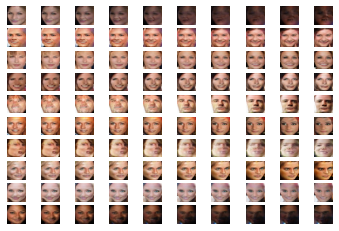

In [ ]:
# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, 10, 10)

The result is 10 more transitions between generated faces, this time using the correct Slerp interpolation method.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

The difference is subtle but somehow visually more correct.

### How to Perform Vector Arithmetic With Faces
Finally, we can explore the latent space by performing vector arithmetic with the generated faces.

First, we must generate a large number of faces and save both the faces and their corresponding latent vectors. We can then review the plot of generated faces and select faces with features we’re interested in, note their index (number), and retrieve their latent space vectors for manipulation.

The example below will load the GAN model and use it to generate 100 random faces.

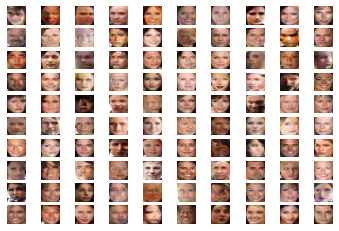

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
from numpy import savez_compressed
from numpy.random import seed

seed(12)

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
latent_points = generate_latent_points(100, 100)
# save points
savez_compressed('latent_points.npz', latent_points)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# save plot
plot_generated(X, 10, 10)

Running the example loads the model, generates faces, and saves the latent vectors and generated faces.

The latent vectors are saved to a compressed NumPy array with the filename ‘latent_points.npz‘. The 100 generated faces are plotted in a 10×10 grid and saved in a file named ‘generated_faces.png‘.

In this case, we have a good collection of faces to work with. Each face has an index that we can use to retrieve the latent vector. For example, the first face is 1, which corresponds to the first vector in the saved array (index 0).

We will perform the operation:

smiling woman - neutral woman + neutral man = smiling man

Therefore, we need three faces for each of smiling woman, neutral woman, and neutral man.

In this case, we will use the following indexes in the image:

- Smiling Woman: 5, 6, 98
- Neutral Woman: 33, 53, 62
- Neutral Man: 31, 36, 94

Now that we have latent vectors to work with and a target arithmetic, we can get started.

First, we can specify our preferred images and load the saved NumPy array of latent points.

In [ ]:
from numpy import load

# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# retrieve specific points
smiling_woman_ix = [5, 6, 98]
neutral_woman_ix = [33, 53, 62]
neutral_man_ix = [31, 36, 94]

Next, we can retrieve each vector and calculate the average for each vector type (e.g. smiling woman). We could perform vector arithmetic with single images directly, but we will get a more robust result if we work with an average of a few faces with the desired property.

The average_points() function below takes the loaded array of latent space points, retrieves each, calculates the average, and returns all of the vectors.

In [ ]:
from numpy import mean
from numpy import vstack

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

We can now use this function to retrieve all of the required points in latent space and generate images.

In [ ]:
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_generated(images, 3, 4)

Finally, we can use the average vectors to perform vector arithmetic in latent space and plot the result.

In [ ]:
from numpy import expand_dims
from matplotlib import pyplot

# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

Tying this together, the complete example is listed below.

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import seed
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

seed(12)

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# retrieve specific points
smiling_woman_ix = [5, 6, 98]
neutral_woman_ix = [33, 53, 62]
neutral_man_ix = [31, 36, 94]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_generated(images, 3, 4)
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

Running the example first loads the points in latent space for our specific images, calculates the average of the points, and generates the faces for the points.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

We can see that, indeed, our selected faces were retrieved correctly and that the average of the points in the vector space captures the salient feature we are going for on each line (e.g. smiling woman, neutral woman, etc.).

Next, vector arithmetic is performed and the result is a smiling man, as we would expect.


## Summary
In this tutorial, you discovered how to develop a generative adversarial network for face generation and explore the structure of latent space and the effect on generated faces.

Specifically, you learned:

- How to develop and evaluate a generative adversarial network for generating faces.
- How to interpolate between points in latent space and generate images that morph from one face to another.
- How to perform vector arithmetic in latent space and achieve targeted results in the resulting generated faces.

## Acknowledgment
This tutorial was written by Jason Brownlee in [Generative Adversarial Networks](https://machinelearningmastery.com/category/generative-adversarial-networks/).